# FCC Pythia + Delphes + Heppy Analysis

-   [Overview](#Overview)
-   [Generate and Simulate Events](#Part-I:-Generate-and-simulate-Events-with-FCCSW)
-   [Analyze Events](#Part-II:-Analyze-the-output-with-Heppy)
-   [Plot events](#Part-III:-Produce-plots)
-   [Homework exercise](#Part-IV:-Homework)

## Overview

This tutorial will teach you how to:

-   **generate** signal and background samples with **Pythia8** within FCCSW
-   run a fast parametric **detector simulation** with **Delphes** within FCCSW
-   apply an **event selection** on those samples with **Heppy**
-   produce **flat ntuples** with observables of interest with Heppy
-   produce plots


But first, make sure your **setup of the FCC software** is working correctly. A quick check is that the executable `fccrun`, which allows you to run jobs in the Gaudi framework is available on the command line:


In [4]:
!which fccrun

/usr/local/scripts//fccrun


If the above command fails without printing a path like `/cvmfs/fcc.cern.ch/sw/releases/fccsw/0.10/x86_64-centos7-gcc62-opt/scripts/fccrun` check [**the documentation page on FCC software setup**](https://github.com/HEP-FCC/fcc-tutorials/blob/master/FccSoftwareGettingStarted.md).

## Part I: Generate and simulate Events with FCCSW

For this tutorial we will consider the following **physics processes**:

-   p p -> H -> 4 l
-   p p -> Z/gamma Z/gamma -> 4 l

Pythia can be configured to hadronize previously generated hard scattering in the form of Les Houches event files (`.lhe`),
or generate the hard process itself and then run the parton shower and hadronization.
**In either case, the FCCSW takes as input a Pythia8 configuration file** (`.cmd`), and does not need to know which approach was used. 

For this tutorial, we are going to run Pythia8 on previously produced LHE files (with [MG5_aMCatNLO](https://launchpad.net/mg5amcnlo)).
Additional Pythia8 configurations can be found in `FCCSW/Generation/data`.

In [ ]:
%%writefile Pythia_pp_h_4l.cmd
! File: Pythia_LHEinput.cmd 
!
! This file contains commands to be read in for a Pythia8 run.
! Lines not beginning with a letter or digit are comments.
! Names are case-insensitive  -  but spellings-sensitive!
! Adjusted from Pythia example: main42.cmnd

! 1) Settings that will be used in a main program.
Main:numberOfEvents = 1            ! number of events to generate
Main:timesAllowErrors = 3          ! abort run after this many flawed events
#Random:seed = 1234                ! initialize random generator with a seed


! 2) Settings related to output in init(), next() and stat() functions.
Init:showChangedSettings = on      ! list changed settings
Init:showAllSettings = off         ! list all settings
Init:showChangedParticleData = on  ! list changed particle data
Init:showAllParticleData = off     ! list all particle data
Next:numberCount = 10              ! print message every n events
Next:numberShowLHA = 1             ! print LHA information n times
Next:numberShowInfo = 1            ! print event information n times
Next:numberShowProcess = 1         ! print process record n times
Next:numberShowEvent = 1           ! print event record n times
Stat:showPartonLevel = off         ! additional statistics on MPI

! 3b) PDF settings. Default is to use internal PDFs
! some pdf sets examples: cteq61.LHpdf cteq61.LHgrid MRST2004nlo.LHgrid
#PDF:pSet = LHAPDF5:MRST2001lo.LHgrid
! Allow extrapolation of PDF's beyond x and Q2 boundaries, at own risk.
! Default behaviour is to freeze PDF's at boundaries.
#PDF:extrapolate = on

! 4) Read-in Les Houches Event file - alternative beam and process selection.
Beams:frameType = 4                      ! read info from a LHEF
Beams:LHEF = pp_h_4l.lhe

! 5) Other settings. Can be expanded as desired.
! Note: may overwrite some of the values above, so watch out.


The detector response of the the baseline FCC-hh detector configuration is calculated with Delphes.
Other detector cards can be found in the `$DELPHES_DIR/cards` directory, such as a ATLAS, CMS or ILD detector configurations:
`delphes_card_ATLAS.tcl`, `delphes_card_CMS.tcl` and `delphes_card_ILD.tcl`. Many of the questions you might have on Delphes Fast Simulation are probably answered
[here](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook).

Both Pythia8 and Delphes are integrated in the Gaudi-based FCCSW framework as *Algorithms*. A job that runs the whole workflow consists of the following:

* `GenAlg` (Top level Generation Algorithm, with a `tool` that calls Pythia8)
* `HepMCConverter` (takes the HepMC output and translates it to the FCC event data model, understood by the Sim Algorithm)
* `DelphesSimulation`(Delphes integration, outputs reconstructed objects in the FCC event data model)
* `PodioOutput` (writes the event data to a root file on disk)

To run this job, a job options like the following is needed (**Note:** While the format of the configuration is a python file, it is not necessarily "pythonic". It can be used with GaudiPython, but we will only use it as to straightforwardly write down a job description for use with `fccrun` ) 

In [14]:
%%writefile PythiaDelphes_config.py
from Gaudi.Configuration import *

# Workflow Steering
from Configurables import ApplicationMgr
ApplicationMgr().EvtSel = 'NONE'
ApplicationMgr().EvtMax = 100

## Data event model based on Podio
from Configurables import FCCDataSvc
podioEvent = FCCDataSvc("EventDataSvc")
ApplicationMgr().ExtSvc += [podioEvent]
ApplicationMgr().OutputLevel = INFO

## Pythia generator
from Configurables import PythiaInterface
pythia8gentool = PythiaInterface()
pythia8gentool.Filename = "Generation/data/Pythia_ttbar.cmd"

## Write the HepMC::GenEvent to the data service
from Configurables import GenAlg
pythia8gen = GenAlg()
pythia8gen.SignalProvider = pythia8gentool
pythia8gen.hepmc.Path = "hepmc"
ApplicationMgr().TopAlg += [pythia8gen]

### Reads an HepMC::GenEvent from the data service and writes a collection of EDM Particles
from Configurables import HepMCToEDMConverter
hepmc_converter = HepMCToEDMConverter("Converter")
hepmc_converter.hepmc.Path = "hepmc"
hepmc_converter.genparticles.Path = "genParticles"
hepmc_converter.genvertices.Path = "genVertices"
ApplicationMgr().TopAlg += [hepmc_converter]

# Define all output tools that convert the Delphes collections to FCC-EDM:

from Configurables import DelphesSaveChargedParticles

muonSaveTool = DelphesSaveChargedParticles("muons")
muonSaveTool.delphesArrayName = "MuonMomentumSmearing/muons"
muonSaveTool.particles.Path      = "muons"
muonSaveTool.mcAssociations.Path = "muonsToMC"
muonSaveTool.isolationTags.Path  = "muonITags"

eleSaveTool = DelphesSaveChargedParticles("electrons")
eleSaveTool.delphesArrayName = "ElectronFilter/electrons"
eleSaveTool.particles.Path      = "electrons"
eleSaveTool.mcAssociations.Path = "electronsToMC"
eleSaveTool.isolationTags.Path  = "electronITags"

chhadSaveTool = DelphesSaveChargedParticles("pfcharged")
chhadSaveTool.delphesArrayName = "ChargedHadronFilter/chargedHadrons"
chhadSaveTool.saveIsolation = False
chhadSaveTool.particles.Path      = "pfcharged"
chhadSaveTool.mcAssociations.Path = "pfchargedToMC"


from Configurables import DelphesSaveNeutralParticles

# Particle-Flow Neutral Hadrons output tool
neuthadSaveTool = DelphesSaveNeutralParticles("pfneutrals")
neuthadSaveTool.delphesArrayName = "HCal/eflowNeutralHadrons"
neuthadSaveTool.saveIsolation = False
neuthadSaveTool.particles.Path      = "pfneutrals"
neuthadSaveTool.mcAssociations.Path = "pfneutralsToMC"

# Particle-Flow Photons output tool
pfphotonsSaveTool = DelphesSaveNeutralParticles("pfphotons")
pfphotonsSaveTool.delphesArrayName="ECal/eflowPhotons"
pfphotonsSaveTool.saveIsolation=False
pfphotonsSaveTool.particles.Path      = "pfphotons"
pfphotonsSaveTool.mcAssociations.Path = "pfphotonsToMC"
pfphotonsSaveTool.isolationTags.Path  = "pfphotonITags"

# Photons output tool
photonsSaveTool = DelphesSaveNeutralParticles("photons")
photonsSaveTool.delphesArrayName = "PhotonEfficiency/photons"
photonsSaveTool.particles.Path      = "photons"
photonsSaveTool.mcAssociations.Path = "photonsToMC"
photonsSaveTool.isolationTags.Path  = "photonITags"


from Configurables import DelphesSaveGenJets
genJetSaveTool = DelphesSaveGenJets("genJets")
genJetSaveTool.delphesArrayName = "GenJetFinder/jets"
genJetSaveTool.genJets.Path             = "genJets"
genJetSaveTool.genJetsFlavorTagged.Path = "genJetsFlavor"


from Configurables import DelphesSaveJets
jetSaveTool = DelphesSaveJets("jets")
jetSaveTool.delphesArrayName = "JetEnergyScale/jets"
jetSaveTool.jets.Path             = "jets"
jetSaveTool.jetConstituents.Path  = "jetParts"
jetSaveTool.jetsFlavorTagged.Path = "jetsFlavor"
jetSaveTool.jetsBTagged.Path      = "bTags"
jetSaveTool.jetsCTagged.Path      = "cTags"
jetSaveTool.jetsTauTagged.Path    = "tauTags"

fatjetSaveTool = DelphesSaveJets("fatjets")
fatjetSaveTool.delphesArrayName = "FatJetFinder/jets"
fatjetSaveTool.saveSubstructure = True
fatjetSaveTool.jets.Path                        = "fatjets"
fatjetSaveTool.jetConstituents.Path             = "fatjetParts"
fatjetSaveTool.jetsOneSubJettinessTagged.Path   = "jetsOneSubJettiness"
fatjetSaveTool.jetsTwoSubJettinessTagged.Path   = "jetsTwoSubJettiness"
fatjetSaveTool.jetsThreeSubJettinessTagged.Path = "jetsThreeSubJettiness"
fatjetSaveTool.subjetsTrimmingTagged.Path       = "subjetsTrimmingTagged"
fatjetSaveTool.subjetsPruningTagged.Path        = "subjetsPruningTagged"
fatjetSaveTool.subjetsPruning.Path              = "subjetsPruning"
fatjetSaveTool.subjetsSoftDropTagged.Path       = "subjetsSoftDropTagged"
fatjetSaveTool.subjetsSoftDrop.Path             = "subjetsSoftDrop"
fatjetSaveTool.subjetsTrimming.Path             = "subjetsTrimming"

from Configurables import DelphesSaveMet
metSaveTool = DelphesSaveMet("met")
metSaveTool.delphesMETArrayName = "MissingET/momentum"
metSaveTool.delphesSHTArrayName = "ScalarHT/energy"
metSaveTool.missingEt.Path = "met"


## Delphes simulator -> define objects to be written out
from Configurables import DelphesSimulation
delphessim = DelphesSimulation()
## Define Delphes card
delphessim.DelphesCard = "FCChh_DelphesCard_Baseline_v01.tcl"
delphessim.ROOTOutputFile = ""
delphessim.ApplyGenFilter = True
delphessim.outputs = [
                       "DelphesSaveChargedParticles/muons",
                       "DelphesSaveChargedParticles/electrons",
                       "DelphesSaveNeutralParticles/photons",
                       "DelphesSaveChargedParticles/pfcharged",
                       "DelphesSaveNeutralParticles/pfphotons",
                       "DelphesSaveNeutralParticles/pfneutrals",
                       "DelphesSaveGenJets/genJets",
                       "DelphesSaveJets/jets",
                       "DelphesSaveJets/fatjets",                                        
                       "DelphesSaveMet/met",
                     ]
delphessim.hepmc.Path               = "hepmc"
delphessim.genParticles.Path        = "skimmedGenParticles"
delphessim.mcEventWeights.Path      = "mcEventWeights"
ApplicationMgr().TopAlg += [delphessim]



## FCC event-data model output -> define objects to be written out
from Configurables import PodioOutput
out = PodioOutput("out")
out.filename = "FCCDelphesOutput.root"
out.outputCommands = [
                       "keep *", 
                     ]
ApplicationMgr().TopAlg += [out]




Overwriting PythiaDelphes_config.py


The `fccrun` allows to change most `Properties` of the job on the command line. All possible arguments to fccrun  are listed with the command 

In [6]:
!fccrun PythiaDelphes_config.py -h

 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

usage: fccrun [-h] [--dry-run] [-v] [-n NUM_EVENTS] [-l] [--gdb]
              [--ncpus NCPUS] [--ROOTOutputFile [ROOTOUTPUTFILE]]
              [--ApplyGenFilter [APPLYGENFILTER]]
              [--outputs OUTPUTS [OUTPUTS ...]] [--DelphesCard [DELPHESCARD]]
              [--PrintEmptyCounters [PRINTEMPTYCOUNTERS]] [--input [INPUT]]
              [--Filename [FILENAME]]
              [--printPythiaStatistics [PRINTPYTHIASTATISTICS]]
              [--outputCommands OUTPUTCOMMANDS [OUTPUTCOMMANDS ...]]
              [--filename [FILENAME]]
              [--hepmcStatusList HEPMCSTATUSLIST [HEPMCSTATUSLIST ...]]
              [config_files [config_files ...]]

Run job in the FCC framework

positional arguments:
  config_files          Gaudi config (python) files describing the job

optional arguments:
  -h, --help            show this help message and exit
  --dry-run             Do not actually run the job, just parse the c

Thus The following commands will run Pythia8 and Delphes and produce the relevant signal and background samples:

In [7]:
!fccrun PythiaDelphes_config.py --Filename Pythia_pp_h_4l.cmd --filename pp_h_4l.root -n 100

 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v29r2)
                                          running on b77fde583839 on Thu Aug 15 12:13:51 2019
ApplicationMgr       INFO Application Manager Configured successfully
** INFO: adding module        ParticlePropagator       ParticlePropagator       
** INFO: adding module        Efficiency               ChargedHadronTrackingEfficiency
** INFO: adding module        Efficiency               ElectronTrackingEfficiency
** INFO: adding module        Efficiency               MuonTrackingEfficiency   
** INFO: adding module        MomentumSmearing         ChargedHadronMomentumSmearing
** INFO: adding module        MomentumSmearing         ElectronMomentumSmearing 
** INFO: adding module        MomentumSmearing         MuonMomentumSmearing     
** INFO: adding module        Merger                   TrackMerger 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.240      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 20 Dec 2018  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 15 Aug 2019 at 12:13:54    |  | 
 |  |                                                                              |  | 
 |  |   Christian Bi


 --------  LHA event information and listing  ---------------------------------------------------------------------- 

    process =        2    weight =   2.6322e-02     scale =   1.2500e+02 (GeV) 
                        alpha_em =   7.5468e-03    alpha_strong =   1.2351e-01

    Participating Particles 
    no        id stat     mothers     colours      p_x        p_y        p_z         e          m        tau    spin 
     1        21   -1     0     0   502   501      0.000      0.000    166.600    166.600      0.000   0.000  -1.000
     2        21   -1     0     0   501   502     -0.000     -0.000    -23.446     23.446      0.000   0.000  -1.000
     3        25    2     1     2     0     0      0.000      0.000    143.154    190.046    124.997   0.000   0.000
     4        23    2     3     3     0     0      4.077    -15.742    128.367    158.069     90.793   0.000   0.000
     5       -13    1     3     3     0     0     -6.588      2.136     -4.486      8.252      0.000   0.

  1545         21  (g)                -62  1097  1097  1750     0   796   783 -4.885e-01 -2.107e-01 -8.799e+00  8.816e+00  0.000e+00
  1546         21  (g)                -62  1200  1200  1753     0   538   795  1.988e-01 -1.955e-02  1.168e+00  1.185e+00  0.000e+00
  1547         21  (g)                -62  1181  1181  1780     0   843   652  6.286e-01  1.349e+00 -1.381e+02  1.381e+02  0.000e+00
  1548         21  (g)                -62  1199  1199  1790     0   837   828  1.733e+00  5.182e+00  1.125e+01  1.251e+01  0.000e+00
  1549         21  (g)                -62  1217  1217  2182  2182   541   646 -8.899e-01  2.594e-01 -2.984e+00  3.124e+00  0.000e+00
  1550         21  (g)                -62  1269  1269  1970  1970   874   855 -1.268e+00 -3.502e+00 -5.474e+01  5.486e+01  0.000e+00
  1551         21  (g)                -61     1     0  1292  1292   582   582  2.486e+00  4.408e-01  4.869e+01  4.876e+01  0.000e+00
  1552         21  (g)                -61     2     0  1293  1293   8

  3745         22  gamma               91  3064     0     0     0     0     0 -3.731e-01  2.311e-01 -4.861e+02  4.861e+02  0.000e+00
  3746         22  gamma               91  3072     0     0     0     0     0  5.540e-02  3.795e-02  6.736e-01  6.770e-01  0.000e+00
  3747         22  gamma               91  3072     0     0     0     0     0  2.759e-01  1.936e-01  1.401e+00  1.441e+00  0.000e+00
  3748         22  gamma               91  3073     0     0     0     0     0  8.653e-02 -1.403e-02  5.280e-01  5.352e-01  0.000e+00
  3749         22  gamma               91  3073     0     0     0     0     0  3.513e-01  4.946e-02  1.049e+00  1.107e+00  0.000e+00
  3750         22  gamma               91  3074     0     0     0     0     0  2.809e-01  1.446e-01  1.217e+00  1.257e+00  0.000e+00
  3751         22  gamma               91  3074     0     0     0     0     0  2.358e-02  8.587e-02  3.314e-01  3.431e-01  0.000e+00
  3752         22  gamma               91  3077     0     0     0    

Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleHit.h
   requested to autoload type ConstExampleHit
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterConst.h
   requested to autoload type ConstExampleCluster
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterData.h
   requested to autoload type ExampleClusterData
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency1Data.h
   requested to autoload type ExampleForCyclicDependency1Data
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Const.h
   requested to autoload type ConstExampleForCyclicDependency2
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Data.h
   requested to autoload type Example

In [8]:
!fccrun PythiaDelphes_config.py --Filename Pythia_pp_zgzg_4l.cmd --filename pp_zgzg_4l.root -n 100

 -->  GenAlg  -->  Converter  -->  DelphesSimulation  -->  out  

ApplicationMgr    SUCCESS 
                                                   Welcome to ApplicationMgr (GaudiCoreSvc v29r2)
                                          running on b77fde583839 on Thu Aug 15 12:15:18 2019
ApplicationMgr       INFO Application Manager Configured successfully
** INFO: adding module        ParticlePropagator       ParticlePropagator       
** INFO: adding module        Efficiency               ChargedHadronTrackingEfficiency
** INFO: adding module        Efficiency               ElectronTrackingEfficiency
** INFO: adding module        Efficiency               MuonTrackingEfficiency   
** INFO: adding module        MomentumSmearing         ChargedHadronMomentumSmearing
** INFO: adding module        MomentumSmearing         ElectronMomentumSmearing 
** INFO: adding module        MomentumSmearing         MuonMomentumSmearing     
** INFO: adding module        Merger                   TrackMerger 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.240      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 20 Dec 2018  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 15 Aug 2019 at 12:15:22    |  | 
 |  |                                                                              |  | 
 |  |   Christian Bi


 --------  LHA event information and listing  ---------------------------------------------------------------------- 

    process =        1    weight =   1.0377e+00     scale =   2.5702e+02 (GeV) 
                        alpha_em =   7.5468e-03    alpha_strong =   1.1090e-01

    Participating Particles 
    no        id stat     mothers     colours      p_x        p_y        p_z         e          m        tau    spin 
     1        -2   -1     0     0     0   501     -0.000      0.000     59.297     59.297      0.000   0.000   1.000
     2         2   -1     0     0   501     0      0.000     -0.000  -1240.981   1240.981      0.000   0.000  -1.000
     3        23    2     1     2     0     0   -209.481    117.680   -799.269    839.578     91.270   0.000   0.000
     4        23    2     1     2     0     0    209.481   -117.680   -382.415    460.699     90.948   0.000   0.000
     5       -11    1     4     4     0     0     20.887    -45.158   -116.875    127.025      0.000   0.

  1428         21  (g)                -52  1191  1191  1754  1754   850   618 -5.860e-01  3.766e+00 -5.935e+03  5.935e+03  0.000e+00
  1429         21  (g)                -51   966     0  1757  1757   924   508  8.912e-01 -1.495e-01 -3.622e+01  3.623e+01  0.000e+00
  1430         21  (g)                -51   966     0  1779  1779   641   924 -9.268e-02  3.192e-01 -8.542e+01  8.542e+01  0.000e+00
  1431         21  (g)                -52   965   965  1766  1766   776   641 -1.215e-01  2.136e-01 -4.488e+02  4.488e+02  0.000e+00
  1432         21  (g)                -51  1277     0  2117  2117   925   637 -3.576e-01  1.862e+00 -6.944e-01  2.019e+00  0.000e+00
  1433         21  (g)                -51  1277     0  2133  2133   876   925 -3.752e-02 -1.832e-01  1.337e-01  2.299e-01  0.000e+00
  1434         -1  (dbar)             -53  2113  2113   916   916     0   637 -4.555e-16  3.553e-15 -1.492e+01  1.492e+01  0.000e+00
  1435         21  (g)                -51  1336     0  1953  1953   9

  3611        111  (pi0)              -91  3142     0  4311  4312     0     0  1.004e+00  1.623e-01 -1.233e+01  1.237e+01  1.350e-01
  3612        211  pi+                 91  3145     0     0     0     0     0  1.003e+00  6.182e-01 -2.540e+01  2.542e+01  1.396e-01
  3613        111  (pi0)              -91  3145     0  4313  4314     0     0  1.220e-02  3.740e-01 -8.744e+00  8.753e+00  1.350e-01
  3614        310  (K_S0)             -91  3146  3146  4315  4316     0     0  6.094e-01  5.562e-01 -2.595e+01  2.597e+01  4.976e-01
  3615        211  pi+                 91  3148     0     0     0     0     0  1.968e-01  2.430e-01 -4.279e+00  4.293e+00  1.396e-01
  3616        111  (pi0)              -91  3148     0  4317  4318     0     0  2.461e-01  5.089e-02 -2.150e+01  2.151e+01  1.350e-01
  3617        311  (K0)               -91  3149     0  3734  3734     0     0  5.467e-01  7.705e-01 -5.225e+01  5.226e+01  4.976e-01
  3618        111  (pi0)              -91  3149     0  4319  4320    

RndmGenSvc.Engine    INFO Generator engine type:CLHEP::RanluxEngine
RndmGenSvc.Engine    INFO Current Seed:1234567 Luxury:3
RndmGenSvc           INFO Using Random engine:HepRndm::Engine<CLHEP::RanluxEngine>
GenAlg.VertexSm...   INFO Smearing of interaction point with flat distribution  in x, y and z 
GenAlg.VertexSm...   INFO  applying TOF of interaction with positive beam direction
GenAlg.VertexSm...   INFO  with 0 mm <= x <= 0 mm, 0 mm <= y <= 0 mm and 0 mm <= z <= 0 mm.
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleHit.h
   requested to autoload type ConstExampleHit
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterConst.h
   requested to autoload type ConstExampleCluster
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterData.h
   requested to autoload type ExampleClusterData
Error in cling::AutoloadingVisitor::InsertIntoAutoload


 Pythia::next(): 70 events have been generated 

 Pythia::next(): 80 events have been generated 

 Pythia::next(): 90 events have been generated 
ApplicationMgr       INFO Application Manager Stopped successfully
DelphesSimulation    INFO Exiting Delphes...
EventLoopMgr         INFO Histograms converted successfully according to request.
ToolSvc              INFO Removing all tools created by ToolSvc
ApplicationMgr       INFO Application Manager Finalized successfully
ApplicationMgr       INFO Application Manager Terminated successfully


For a complete discussion on the structure of configuration file, see [this page](https://github.com/HEP-FCC/FCCSW/blob/master/Sim/SimDelphesInterface/doc/FccPythiaDelphes.md).
Aside from I/O and number of events (which can be specified through command line),
for most use cases as a user you won't need to apply any change to the configuration file.

In addition to the **sequence of modules** to be executed, and which **output collections** to be stored in the output tree, the following
parameters can be specified via the configuration file:

The output is a ROOT file containing a tree in the FCC [Event Data Model structure](https://github.com/HEP-FCC/fcc-edm). It is browsable with ROOT:




In [9]:
!rootls -t pp_h_4l.root

Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleHit.h
   requested to autoload type ConstExampleHit
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterConst.h
   requested to autoload type ConstExampleCluster
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterData.h
   requested to autoload type ExampleClusterData
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency1Data.h
   requested to autoload type ExampleForCyclicDependency1Data
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Const.h
   requested to autoload type ConstExampleForCyclicDependency2
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Data.h
   requested to autoload type Example

    electrons#0.index         "index[electrons#0_]"         494
    electrons#0.collectionID  "collectionID[electrons#0_]"  501
  electrons#1              "electrons#1_"              888
    electrons#1.index         "index[electrons#1_]"         494
    electrons#1.collectionID  "collectionID[electrons#1_]"  501
  electronsToMC            "electronsToMC"             4060
  electronsToMC#0          "electronsToMC#0_"          892
    electronsToMC#0.index         "index[electronsToMC#0_]"         1526
    electronsToMC#0.collectionID  "collectionID[electronsToMC#0_]"  1533
  electronsToMC#1          "electronsToMC#1_"          892
    electronsToMC#1.index         "index[electronsToMC#1_]"         1526
    electronsToMC#1.collectionID  "collectionID[electronsToMC#1_]"  1533
  electronITags            "electronITags_"            890
    electronITags.tag  "tag[electronITags_]"  1522
  electronITags#0          "electronITags#0_"          892
    electronITags#0.index         "index[elect

It contains the Generation-level particles (`skimmedGenParticles`) as well as the Reconstruction-level Delphes output (`muons`, `electrons` ...)


Plotting some basic quantities directly on this output is possible, although not very handy:

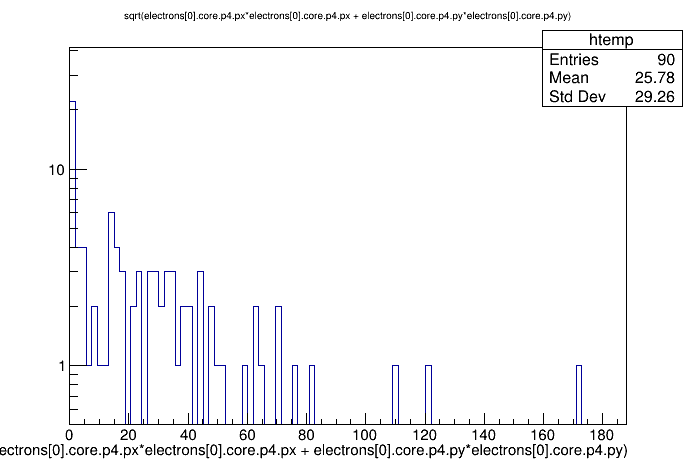

In [8]:
import ROOT
c = ROOT.TCanvas()
f = ROOT.TFile("pp_h_4l.root")
# get event tree
events = f.Get("events")
events.Draw("sqrt(electrons[0].core.p4.px*electrons[0].core.p4.px + electrons[0].core.p4.py*electrons[0].core.p4.py)")
ROOT.gPad.SetLogy()
c.Draw()


To save time and computing power, more events with the same configuration can be taken from eos:

In [12]:
!export EOS_MGM_URL="root://eospublic.cern.ch"
!cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_h_4l.root .
!cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_zgzg_4l.root .



Part II: Analyze the output with Heppy
------------------------------------------


[Heppy](https://github.com/HEP-FCC/heppy) is a python framework suitable for analyzing the FCCSW output.


Understand the configuration file for this **H->4l analysis**: `heppy/test/analysis_pp_hTo4l_simple_cfg.py`
This is where **filters** on input collections and **event selection** are defined.
The sequence is divided in two parts, a gen level analysis, and a reco level.

-   The **gen level analysis** simply filters interesting leptons (`gen_leptons`) and stores pT, eta in in flat tree (`gen_tree`).

Have a look at the corresponding code in `heppy/analyzers/examples/hzz4l/HTo4lGenTreeProducer.py`.

-   The **reco level analysis** first **selects isolated leptons** (`selected_muons`, `selected_electrons`), merges them into a single collection (`selected_leptons`),
**builds Z candidates** (`zeds`) and finally **builds higgs candidates**  (`higgses`). After that an **event selection** is applied (`selection`).

Open `heppy/analyzers/examples/hzz4l/selection.py` and understand the event selection.

Finally another flat tree is produced `HTo4lTreeProducer`.
This tree contains contains all relevant information for the two reconstructed Z bosons, the Higgs, and the four associated leptons.
For comparison, also the MC level counterparts of the reconstructed quantities are stored.

To summarize, when designing a new analysis, you will have to define:

- a configuration file containing the analysis sequence
- an event selection
- one or several tree producer(s) where the variables to be stored in the output tree(s) are specified
- optionally, new modules that are specific to your analysis (e.g. `LeptonicZedBuilder` here)

Now run HEPPY:

In [ ]:
!heppy_loop.py pp_h_4l heppy/heppy/test/analysis_pp_hTo4l_simple_cfg.py -N 1000 -I pp_h_4l.root;


Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleHit.h
   requested to autoload type ConstExampleHit
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterConst.h
   requested to autoload type ConstExampleCluster
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterData.h
   requested to autoload type ExampleClusterData
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency1Data.h
   requested to autoload type ExampleForCyclicDependency1Data
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Const.h
   requested to autoload type ConstExampleForCyclicDependency2
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Data.h
   requested to autoload type Example

In [16]:
!heppy_loop.py pp_zgzg_4l heppy/heppy/test/analysis_pp_hTo4l_simple_cfg.py -N 1000 -I pp_zgzg_4l.root;

Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleHit.h
   requested to autoload type ConstExampleHit
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterConst.h
   requested to autoload type ConstExampleCluster
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleClusterData.h
   requested to autoload type ExampleClusterData
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency1Data.h
   requested to autoload type ExampleForCyclicDependency1Data
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Const.h
   requested to autoload type ConstExampleForCyclicDependency2
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for ExampleForCyclicDependency2Data.h
   requested to autoload type Example

The runs create two output directories `pp_h_4l` and `pp_zgzg_4l`, with various subdirectories. The breakdown of
efficiencies by cut can be found in:

`example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt`

In [7]:
!cat pp_h_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt

Counter cut_flow :
	 All events                                                         100 	 1.00 	 1.0000
	 At least one Z -> l+ l- candidates                                  95 	 0.95 	 0.9500
	 40 < mZ1 < 120                                                      78 	 0.82 	 0.7800
	 At least a second Z -> l+ l- candidates                             49 	 0.63 	 0.4900
	 12 < mZ2 < 120                                                      49 	 1.00 	 0.4900
	 leading lepton pT > 20                                              48 	 0.98 	 0.4800
	 sub-leading lepton pT > 10                                          48 	 1.00 	 0.4800



In [11]:
!cat pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt

Counter cut_flow :
	 All events                                                         100 	 1.00 	 1.0000
	 At least one Z -> l+ l- candidates                                  93 	 0.93 	 0.9300
	 40 < mZ1 < 120                                                      75 	 0.81 	 0.7500
	 At least a second Z -> l+ l- candidates                             41 	 0.55 	 0.4100
	 12 < mZ2 < 120                                                      27 	 0.66 	 0.2700
	 leading lepton pT > 20                                              27 	 1.00 	 0.2700
	 sub-leading lepton pT > 10                                          27 	 1.00 	 0.2700



The **gen-level** and **reco-level** output trees can be found here:

`example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root`
`example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root`

## Part III: Produce plots


Produce Gen-level plots:

In [6]:

import ROOT
from ROOT import TFile, gROOT, TH1D, kRed, TLegend
import os


def printCanvas(canvas, name, format, directory):
    if format != "":
        if not os.path.exists(directory) :
                os.system("mkdir "+directory)
        outFile = os.path.join(directory, name) + "." + format
        canvas.Print(outFile)



def drawDoublehisto(h1, h2, name, ylabel, legend, leftText, rightText, format, directory, logY):
    if logY : 
        name = name+"_logY"
    canvas = ROOT.TCanvas(name, name, 700, 600) 
    if logY : 
        canvas.SetLogy(1)
    
    font = 132
    
    ROOT.gPad.SetLeftMargin(0.20) ; 
    ROOT.gPad.SetRightMargin(0.10) ; 
    ROOT.gPad.SetBottomMargin(0.20) ; 
    ROOT.gStyle.SetOptStat(0000000);
    ROOT.gStyle.SetTextFont(font);
    
    Tleft = ROOT.TLatex(0.20, 0.92, leftText) 
    Tleft.SetNDC(ROOT.kTRUE) 
    Tleft.SetTextSize(0.044) 
    Tleft.SetTextFont(font) 
    
    Tright = ROOT.TText(0.90, 0.92, rightText) ;
    Tright.SetTextAlign(31);
    Tright.SetNDC(ROOT.kTRUE) 
    Tright.SetTextSize(0.044) 
    Tright.SetTextFont(font) 
    
    maxh = max(h1.GetMaximum(),h2.GetMaximum())
    
    h1.GetXaxis().SetTitleFont(font)
    h1.GetXaxis().SetLabelFont(font)
    
    h1.GetYaxis().SetTitle(ylabel)
    h1.GetYaxis().SetTitleFont(font)
    h1.GetYaxis().SetLabelFont(font)
    h1.GetXaxis().SetTitleOffset(1.5)
    h1.GetYaxis().SetTitleOffset(1.6)
    h1.GetXaxis().SetLabelOffset(0.02)
    h1.GetYaxis().SetLabelOffset(0.02)
    h1.GetXaxis().SetTitleSize(0.06)
    h1.GetYaxis().SetTitleSize(0.06)
    h1.GetXaxis().SetLabelSize(0.06)
    h1.GetYaxis().SetLabelSize(0.06)
    h1.SetNdivisions(505);
    h1.GetYaxis().SetNdivisions(505);

    h1.SetMaximum(1.5*maxh) 
    h1.SetTitle("") 
    h1.Draw("")
    h2.Draw("same")

    legend.SetTextFont(font) 
    legend.Draw() 
    Tleft.Draw() 
    Tright.Draw() 
    printCanvas(canvas, name, format, directory) 
    canvas.Draw()


treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"

Vars = {   
    "lep1vsPt_pt":{"name":"lep1vsPt_pt","title":"p_{T}^{(1)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep2vsPt_pt":{"name":"lep2vsPt_pt","title":"p_{T}^{(2)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep3vsPt_pt":{"name":"lep3vsPt_pt","title":"p_{T}^{(3)} [GeV]","bin":25,"xmin":0,"xmax":50},
    "lep4vsPt_pt":{"name":"lep4vsPt_pt","title":"p_{T}^{(4)} [GeV]","bin":25,"xmin":0,"xmax":50},

    "lep1vsEta_eta":{"name":"lep1vsEta_eta","title":"#eta^{(1)}","bin":25,"xmin":0,"xmax":10},
    "lep2vsEta_eta":{"name":"lep2vsEta_eta","title":"#eta^{(2)}","bin":25,"xmin":0,"xmax":10},
    "lep3vsEta_eta":{"name":"lep3vsEta_eta","title":"#eta^{(3)}","bin":25,"xmin":0,"xmax":10},
    "lep4vsEta_eta":{"name":"lep4vsEta_eta","title":"#eta^{(4)}","bin":25,"xmin":0,"xmax":10}
}


rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)

dict_histoS =  {}
dict_histoB = {}
for var in Vars:
    dict_histoS[var] = TH1D(var+"S", var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"])
    dict_histoB[var] = TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"])



for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))


yAxisLabel = "a. u."

rightText = "GEN"
leftText = "#sqrt{s} = 100 TeV"
format = "png"
outputDirectory = "plots" 

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
    dict_histoS[var].SetLineWidth(3)
    dict_histoS[var].SetLineWidth(3)
    dict_histoB[var].SetLineColor(ROOT.kRed)
   
    try : 
        dict_histoS[var].Scale(1./float(dict_histoS[var].Integral()))
        dict_histoB[var].Scale(1./float(dict_histoB[var].Integral()))
    except ZeroDivisionError :
        print("Can not renormalize because of integral = 0.") 
    
    leg = TLegend(0.50,0.76,0.89,0.89)
    leg.AddEntry(dict_histoS[var],"p p #rightarrow H #rightarrow 4l","l")
    leg.AddEntry(dict_histoB[var],"p p #rightarrow ZZ / Z #gamma^{*} #rightarrow 4l","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)
    #c = ROOT.TCanvas()
    drawDoublehisto(dict_histoS[var],dict_histoB[var],var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0)
    #c.Draw()




Info in <TCanvas::Print>: png file plots/lep3vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep4vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep3vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep2vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep1vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep4vsEta_eta.png has been created
Info in <TCanvas::Print>: png file plots/lep2vsPt_pt.png has been created
Info in <TCanvas::Print>: png file plots/lep1vsPt_pt.png has been created



The plots can be found in the `plots` directory:

![](plots/lep4vsPt_pt.png)

<img src="./images/FccFullAnalysis/lep1vsPt_pt.png" width="400">
<img src="./images/FccFullAnalysis/lep1vsEta_eta.png" width="400">

Produce Reco-level plots:

Appreciate the signal yield for **25 fb-1 of data**. Compare with [ATLAS results](https://arxiv.org/pdf/1408.5191v3.pdf) at 7,8 TeV .

<img src="./images/FccFullAnalysis/higgs_m.png" width="30%">
<img src="./images/FccFullAnalysis/m4l_80_170_allYear_125.png" width="30%">

In [10]:
# %load tutorials/fcc/createRecoHistos.py
from ROOT import TFile, gROOT, TH1D, kRed, TLegend, THStack
#from tools.drawCanvas import *
import os

def printCanvas(canvas, name, format, directory):
    if format != "":
        if not os.path.exists(directory) :
                os.system("mkdir "+directory)
        outFile = os.path.join(directory, name) + "." + format
        canvas.Print(outFile)

        
def drawStack(name, ylabel, legend, leftText, rightText, format, directory, logY, hS, hB):
    if logY : 
        name = name+"_logY"
    canvas = ROOT.TCanvas(name, name, 700, 600) 
    if logY : 
        canvas.SetLogy(1)
    
    font = 132
    
    ROOT.gPad.SetLeftMargin(0.20) ; 
    ROOT.gPad.SetRightMargin(0.10) ; 
    ROOT.gPad.SetBottomMargin(0.20) ; 
    ROOT.gStyle.SetOptStat(0000000);
    ROOT.gStyle.SetTextFont(font);
    
    Tleft = ROOT.TLatex(0.20, 0.92, leftText) 
    Tleft.SetNDC(ROOT.kTRUE) 
    Tleft.SetTextSize(0.044) 
    Tleft.SetTextFont(font) 
    
    Tright = ROOT.TText(0.90, 0.92, rightText) ;
    Tright.SetTextAlign(31);
    Tright.SetNDC(ROOT.kTRUE) 
    Tright.SetTextSize(0.044) 
    Tright.SetTextFont(font) 
    
    # first retrieve maximum 
    maxes = []
    maxes.append(hS.GetMaximum())
    for h in hB:
       maxes.append(h.GetMaximum())
    
    maxh = max(maxes)
     
    # define stacked histo
    hStack = ROOT.THStack("hstack","")
    colors = []
    colors.append(ROOT.kCyan-6);
    colors.append(ROOT.kBlue-6);
    colors.append(ROOT.kGreen-6);
    colors.append(ROOT.kMagenta-6);
    colors.append(ROOT.kOrange-6);
   
    # first plot backgrounds
         
    hB[0].SetLineWidth(2)
    hB[0].SetLineColor(ROOT.kBlack)
    hB[0].SetFillColor(colors[0])
    
    hStack.Add(hB[0])
    
    # now loop over other background (skipping first)
    iterh = iter(hB)
    next(iterh)
    
    for h in iterh:
       h.SetLineWidth(2)
       h.SetLineColor(ROOT.kBlack)
       h.SetFillColor(colors[k])
       hStack.Add(h)
    
    
    # finally add signal on top
    hS.SetLineWidth(2)
    hS.SetLineColor(ROOT.kRed+1)
    hStack.Add(hS)
    
    hStack.Draw("hist")
   
    hStack.GetXaxis().SetTitleFont(font)
    hStack.GetXaxis().SetLabelFont(font)
    hStack.GetXaxis().SetTitle(hB[0].GetXaxis().GetTitle())
    hStack.GetYaxis().SetTitle(ylabel)
    hStack.GetYaxis().SetTitleFont(font)
    hStack.GetYaxis().SetLabelFont(font)
    hStack.GetXaxis().SetTitleOffset(1.5)
    hStack.GetYaxis().SetTitleOffset(1.6)
    hStack.GetXaxis().SetLabelOffset(0.02)
    hStack.GetYaxis().SetLabelOffset(0.02)
    hStack.GetXaxis().SetTitleSize(0.06)
    hStack.GetYaxis().SetTitleSize(0.06)
    hStack.GetXaxis().SetLabelSize(0.06)
    hStack.GetYaxis().SetLabelSize(0.06)
    hStack.GetXaxis().SetNdivisions(505);
    hStack.GetYaxis().SetNdivisions(505);
    hStack.SetMaximum(1.5*maxh) 
    hStack.SetTitle("") 
    
   
    legend.SetTextFont(font) 
    legend.Draw() 
    Tleft.Draw() 
    Tright.Draw() 
    printCanvas(canvas, name, format, directory) 

treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"

# number of generated events
nGenS = 10000
nGenB = 10000

# integrated luminosity
intLumi = 25000

kFactorS = 3.50
kFactorB = 1.80

# MG5 LO XS x BR in (pb)
sigmaS = 0.026
sigmaB = 1.04

weightS = kFactorS*sigmaS*intLumi/nGenS
weightB = kFactorB*sigmaB*intLumi/nGenB

Vars = {   
    "zed1_m":{"name":"zed1_m","title":"m_{ll}^{(1)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "zed2_m":{"name":"zed2_m","title":"m_{ll}^{(2)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "higgs_m":{"name":"higgs_m","title":"m_{4l} [GeV]","bin":36,"xmin":70,"xmax":170},
}

rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)

dict_histoS = {var:TH1D(var+"S",var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}
dict_histoB = {var:TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}




for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)

    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))

#myBTGStyle()

yAxisLabel = "Events / 2.5 GeV"

rightText = "RECO: Delphes-3.4.0"
leftText = "#sqrt{s} = 100 TeV, L = 25 fb^{-1}"
format = "png"
outputDirectory = "plots" 
outFile = outputDirectory+"/plots.root"

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
     
    try : 
        
	# rescale by
        dict_histoS[var].Scale(weightS)
        dict_histoB[var].Scale(weightB)

    except ZeroDivisionError :
        print "Can not renormalize because of integral = 0." 
    
    leg = TLegend(0.69,0.75,0.88,0.88)
    leg.AddEntry(dict_histoB[var],"ZZ / Z #gamma^{*}","f")
    leg.AddEntry(dict_histoS[var],"H(125)","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)

    hS = dict_histoS[var]
    hB = []
    hB.append(dict_histoB[var])

    drawStack(var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0,hS,hB)







Info in <TCanvas::Print>: png file plots/higgs_m.png has been created
Info in <TCanvas::Print>: png file plots/zed2_m.png has been created
Info in <TCanvas::Print>: png file plots/zed1_m.png has been created


![](plots/higgs_m.png)
![](plots/zed2_m.png)
![](plots/zed1_m.png)

Part IV: Homework
---------------------

As an exercise you can **re-run the full analysis with the CMS detector configuration**. 
Additional Delphes cards canbe found in the `$DELPHES_DIR/cards` folder of your Delphes installation. 

Hint: The input Delphes card can be specified in the command line argument: 
```
--DelphesCard /cvmfs/sft.cern.ch/lcg/releases/LCG_94/delphes/3.4.2pre12/x86_64-centos7-gcc62-opt/cards/delphes_card_CMS.tcl
```

You should obtain a plot similar to the following!


![You should obtain a plot similar to this one.](images/FccFullAnalysis/higgs_m_cms.png)

By comparing the CMS and FCC Delphes cards, try to explain:

-  the **event yields difference between 7/8 TeV and 100 TeV** (by comparing the official ATLAS plot with the CMS configuration you just ran at 100 TeV)
-  the **event yields difference at 100 TeV** between the CMS and FCC detector configurations
-  the **difference in the width of Z and H peaks** between the CMS and FCC detector configurations

[]() Other documentation
------------------------

-   [Submit FCCSW jobs using the condor queue](https://github.com/HEP-FCC/fcc-tutorials/blob/master/FccCondor.md)
-   [Submit Heppy jobs using the batch queue](https://github.com/HEP-FCC/heppy/blob/master/doc/Heppy_-_Parallel_Processing.md)
-   [FCCSW webpage](http://fccsw.web.cern.ch/fccsw/index.html)
-   [Pythia8 manual](http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html)
-   [Delphes website](https://cp3.irmp.ucl.ac.be/projects/delphes)

------------------------------------------------------------------------





























